In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
cd '/Users/jbud/Desktop/Galvanize/repos/Capstone-2'

/Users/jbud/Desktop/Galvanize/repos/Capstone-2


In [60]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots

Bring in data from travel from other countries - maybe that would help?
https://travel.trade.gov/view/m-2017-I-001/index.asp

'''
import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

#Define minimum threshold of cases per 1 million people in each state to begin training data on.
#Threshold is the minimum value at which data is output; Used to reduce misleading predictions
#(low new cases count and low social distancing parameters before pandemic)

threshold = 100

class reg_model(object):
    def __init__(self, X, y, log_trans_y=False, day_cutoff = 70):
        self.X = X
        if log_trans_y == True:
            elim_invalid = y.copy()
            elim_invalid[elim_invalid < 0] = 0
            self.y = np.log(elim_invalid + 1)
        else:
            self.y = y
        train_mask = self.X['days_elapsed(t)'] < day_cutoff
        holdout_mask = self.X['days_elapsed(t)'] >= day_cutoff
        self.log_trans_y = log_trans_y
        self.X_train, self.X_test, self.y_train, self.y_test = self.X[train_mask], self.X[holdout_mask], self.y[train_mask], self.y[holdout_mask]
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha=0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha=alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees=50):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. A Y-transform should be applied on the data. 
        '''
        if n_trees == 'optimize':
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(n_estimators=each)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        self.model = RandomForestRegressor(n_estimators=n_trees)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self, print_err_metric = False):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['days_elapsed(t)'] = self.X_test['days_elapsed(t)']
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace=True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            if print_err_metric:
                print('rmse:', rmse)
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            if print_err_metric:
                print('rss: ', rss)
            return rss

    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted

    def plot_model(self, use_smoothed=True, threshold=threshold, save_name = None, xvar = 'days_elapsed'):
        '''
        Use smoothed generates data using moving average. 
        
        '''
        fig, ax = plt.subplots(figsize=(10, 6))
        if self.log_trans_y == True:
            self.y_test = np.e ** self.y_test
        ax.bar(self.X_test.loc[:, xvar],
                self.y_test, color='blue', label="Test Data")
        ax.bar(self.X_train.loc[:, xvar], np.e **
                self.y_train, color='red', label="Training Data")
        if use_smoothed == True:
            x, y = create_spline(self.X[xvar], self.y)
            ax.plot(x, np.e**y, c='green', label='Moving Average - 7 days')
        else:
            x = self.X_test
            y = self.y
            ax.plot(self.X_test.loc[:, xvar],
                    self.y_test, c='green', label='Predicted Data')
        try:
            x_thresh = x[np.where(np.e**y >= threshold)[0][0]]
            ax.axvline(x_thresh, label='Threshold', color='black', ls='--')
        except:
            pass
        ax.legend()
        ax.set_xlabel('Days Since Feb 15')
        ax.set_ylabel('Cases per 1 Million Population')
        ax.set_title('New York COVID-19 New Cases')
        fig.tight_layout()
        if save_name != None:
            fig.savefig('images/{}'.format(save_name))

def clean_data(df, datetime_col=None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df


def replace_initial_values(df, col_change, val_col):
    '''
    When creating new feature columns using difference of existing columns, this function will replace the initial value in val_col of col_change with a 0.
    '''
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df


def create_spline(x, y, t=7):
    #Use moving average of last t points
    y_raw = y.values
    weights = np.repeat(1.0, t) / t
    mov_avgs_y = np.convolve(y_raw, weights, 'valid')
    mov_avgs_x = list(range(x.values[0] + t, x.values[-1] + 2))
    return mov_avgs_x, mov_avgs_y[:len(x) + 1]

def replace_with_moving_averages(df, cols):
    '''
    Replaces applicable rows  in columns with the moving averages of the past 7 days.
    '''
    df_ma = df.copy()
    for col in cols:
        max_index = max(df_ma.index)
        mv_avgs = create_spline(df_ma['days_elapsed'], df_ma[col])[1]
        applicable_row_indices = max_index - len(mv_avgs) + 1
        df_ma.loc[applicable_row_indices:, col] = mv_avgs
    return df_ma

def load_and_clean_data():
    '''
    Sets up and generates dataframe for analysis
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df.sort_values(['state', 'date'], inplace=True)
    covid_df['New_Cases'] = covid_df['cases'].diff()

    covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')
    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    mobility_df.rename(columns={'sub_region_1': 'state'}, inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df[num_cols] = mobility_df[num_cols].apply(
        lambda x: (x + 100)/100)
    states = list(set(mobility_df['state']))
    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
    transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region')
                              & (transp_raw_df['region'].isin(states))].copy()
    #Driving is only available transportation type data available for statewide data
    transp_df.drop(['geo_type', 'alternative_name', 'transportation_type'],
                   axis=1, inplace=True)
    transp_df.set_index('region', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])
    transp_df = transp_df.melt(id_vars=["date"])
    transp_df.rename(columns={'region': 'state'}, inplace=True)

    mobility_df = mobility_df.merge(
        transp_df, how='inner', on=['date', 'state'])
    covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])
    covid_df.rename(columns={'value': 'driving'}, inplace=True)
    covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)

    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #February 15th is earliest data
    min_date = datetime.datetime(2020, 2, 15)
    covid_df['date'] = covid_df['date'].apply(
        lambda x: (x.to_pydatetime() - min_date).days)
    dates = covid_df['date']
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)

    #Importing state populations and land areas - going to convert cases to new cases per capita for better comparison, implement state density
    state_pops = pd.read_csv('data/pop_by_state.csv',
                             header=1, usecols=['State', 'Pop'])
    state_area = pd.read_csv('data/state_area.csv', usecols=['State', 'TotalArea'])
    state_pops.rename(columns={'State': 'state'}, inplace=True)
    state_area.rename(columns={'State': 'state'}, inplace=True)
    state_pops = state_pops.merge(state_area, on = 'state')
    state_pops['pop_density'] = state_pops['Pop'] / state_pops['TotalArea']
    state_pops['Pop'] = state_pops['Pop'] / 1000000
    covid_df = covid_df.merge(state_pops, on = 'state')
    covid_df['New_Cases_per_pop'] = covid_df['New_Cases'] / covid_df['Pop']
    covid_df.drop(['TotalArea', 'New_Cases', 'Pop'], axis = 1, inplace = True)

    #2 missing park values; manually fill them in with average of surrounding value
    covid_df.loc[507, 'parks'] = (covid_df.loc[506, 'parks'] + covid_df.loc[508, 'parks'])/2
    covid_df.loc[514, 'parks'] = (covid_df.loc[513, 'parks'] + covid_df.loc[515, 'parks'])/2
    
    return covid_df

def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def generate_prediction_df(level, test_df, test_targs, columns, predictions=20):
    '''
    This function generates a prediction array based on the level of social distancing. The predetermined sets
    are determined as follows: High: Minimum values for each column (except residential),
    # Medium: inbetween values, Low: 1 (Back to Normal)
    '''
    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                 'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                 'Low': [1, 1, 1, 1, 1, 0.9, 1]
                 }

    if level not in levelDict.keys():
        pred_params = level
    else:
        pred_params = levelDict[level]

    pred_df = rf_model.X.loc[:, 'days_elapsed(t)':].copy()
    pred_df['moving_average'] = rf_model.y
    pred_df.columns = columns
    last_recorded_day = int(test_df['days_elapsed(t)'].max())
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params).T
        pred_df_row.columns = columns[:-1]
        pred_df = pred_df.append(pred_df_row, sort=True)
    pred_df = pred_df[columns]
    prediction_ts = series_to_supervised(
        pred_df, columns=columns, n_in=0, n_out=21, dropnan=False)
    prediction_ts = prediction_ts[prediction_ts['days_elapsed(t)'] <= 82]

    #Filling in Nan in former time series fields for moving average with the average values seen - to fix later
    avg_mov_average = prediction_ts.iloc[:6, -1].mean()
    prediction_ts.fillna(avg_mov_average, inplace=True)
    prediction_ts.drop('moving_average(t+20)', axis=1, inplace=True)
    return prediction_ts

if __name__ == '__main__':
    covid_df = load_and_clean_data()
    mask1 = (covid_df['state'] == 'New York')
    NY_df = covid_df[mask1]
    y = NY_df.pop('New_Cases_per_pop')
    X = NY_df.iloc[:, 1: -1]
    
    smooth_x, smooth_y = create_spline(X['days_elapsed'], y)
    mov_avg_df = pd.DataFrame([smooth_x, smooth_y]).T
    mov_avg_df.columns = ('days_elapsed', 'moving_average')
    mov_avg_df = mov_avg_df[mov_avg_df['moving_average'] >= threshold]
    
    revised_df = NY_df.merge(mov_avg_df, on = 'days_elapsed').iloc[:, 1:]
    
    #Replace features with moving averages
    revised_df = replace_with_moving_averages(
        revised_df, revised_df.columns[1:-1])

    revised_df.drop('pop_density', axis= 1, inplace = True)  #Only one state is currently considered in this study
    values = revised_df.values
    ts_frame_data = series_to_supervised(values, revised_df.columns, 20, 1)
    ts_y = ts_frame_data.pop('moving_average(t)')
    ts_x = ts_frame_data
    rf_model = reg_model(ts_x, ts_y)
    rf_model.rand_forest(n_trees= 'optimize')
    rf_model.evaluate_model()

    #Plots in notebooks/EDA.ipynb

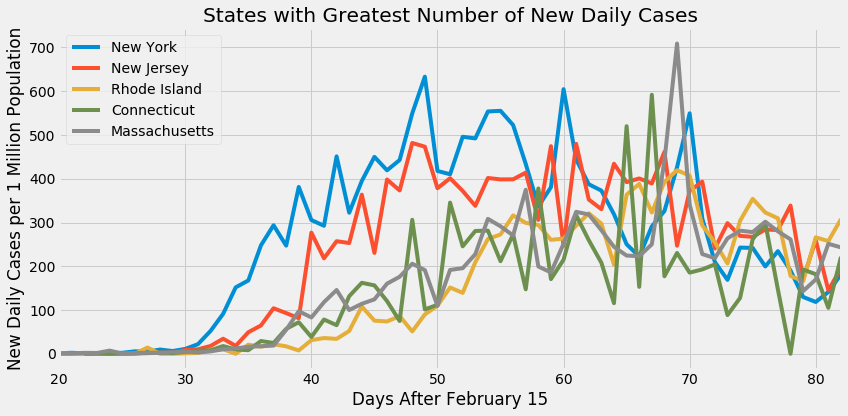

In [131]:
top_states = covid_df[['state','New_Cases_per_pop']].groupby('state').mean()
top_states.sort_values('New_Cases_per_pop', ascending = False, inplace = True)
fig, axes = plt.subplots(figsize = (12,6))
for state in top_states.index[:5]:
    x = covid_df[covid_df['state'] == state].loc[:, 'days_elapsed']
    y = covid_df[covid_df['state'] == state].loc[:, 'New_Cases_per_pop']
    axes.plot(x,y, label = state)
axes.legend()
axes.set_xlabel('Days After February 15')
axes.set_ylabel('New Daily Cases per 1 Million Population')
axes.set_title('States with Greatest Number of New Daily Cases')
axes.set_xlim(20,82)
fig.tight_layout()

In [132]:
fig.savefig('images/Top5States')

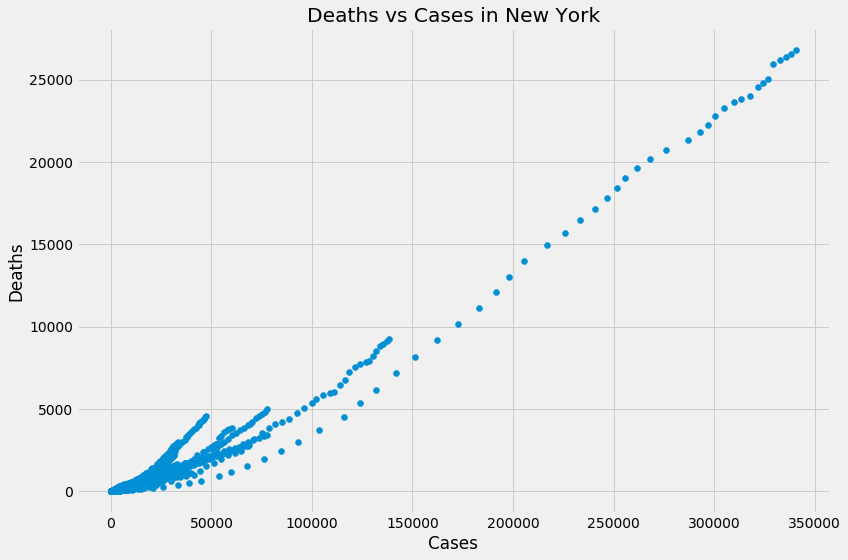

In [148]:
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_raw_df[covid_raw_df['state'] == 'New York']
fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(covid_raw_df['cases'], covid_raw_df['deaths'])
ax.set_title('Deaths vs Cases in New York')
ax.set_xlabel('Cases')
ax.set_ylabel('Deaths')
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases')

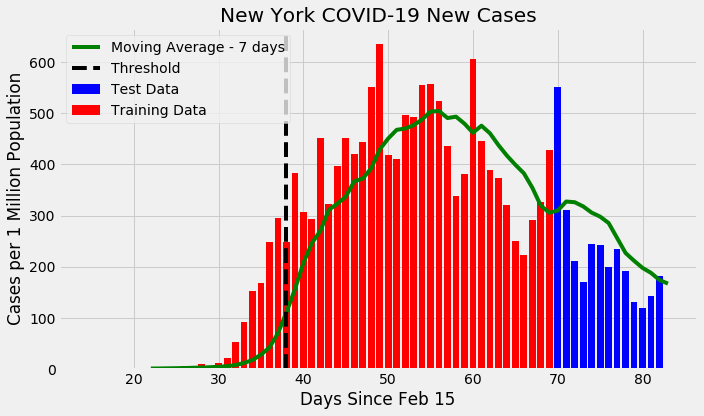

In [248]:
#threshold = 100
rf_model = reg_model(X,y, log_trans_y = True)
NY_New_Cases = rf_model.plot_model(save_name = 'NY_New_100')

In [50]:
from pandas.plotting import scatter_matrix

In [157]:
sm = revised_df.drop('pop_density', axis = 1)

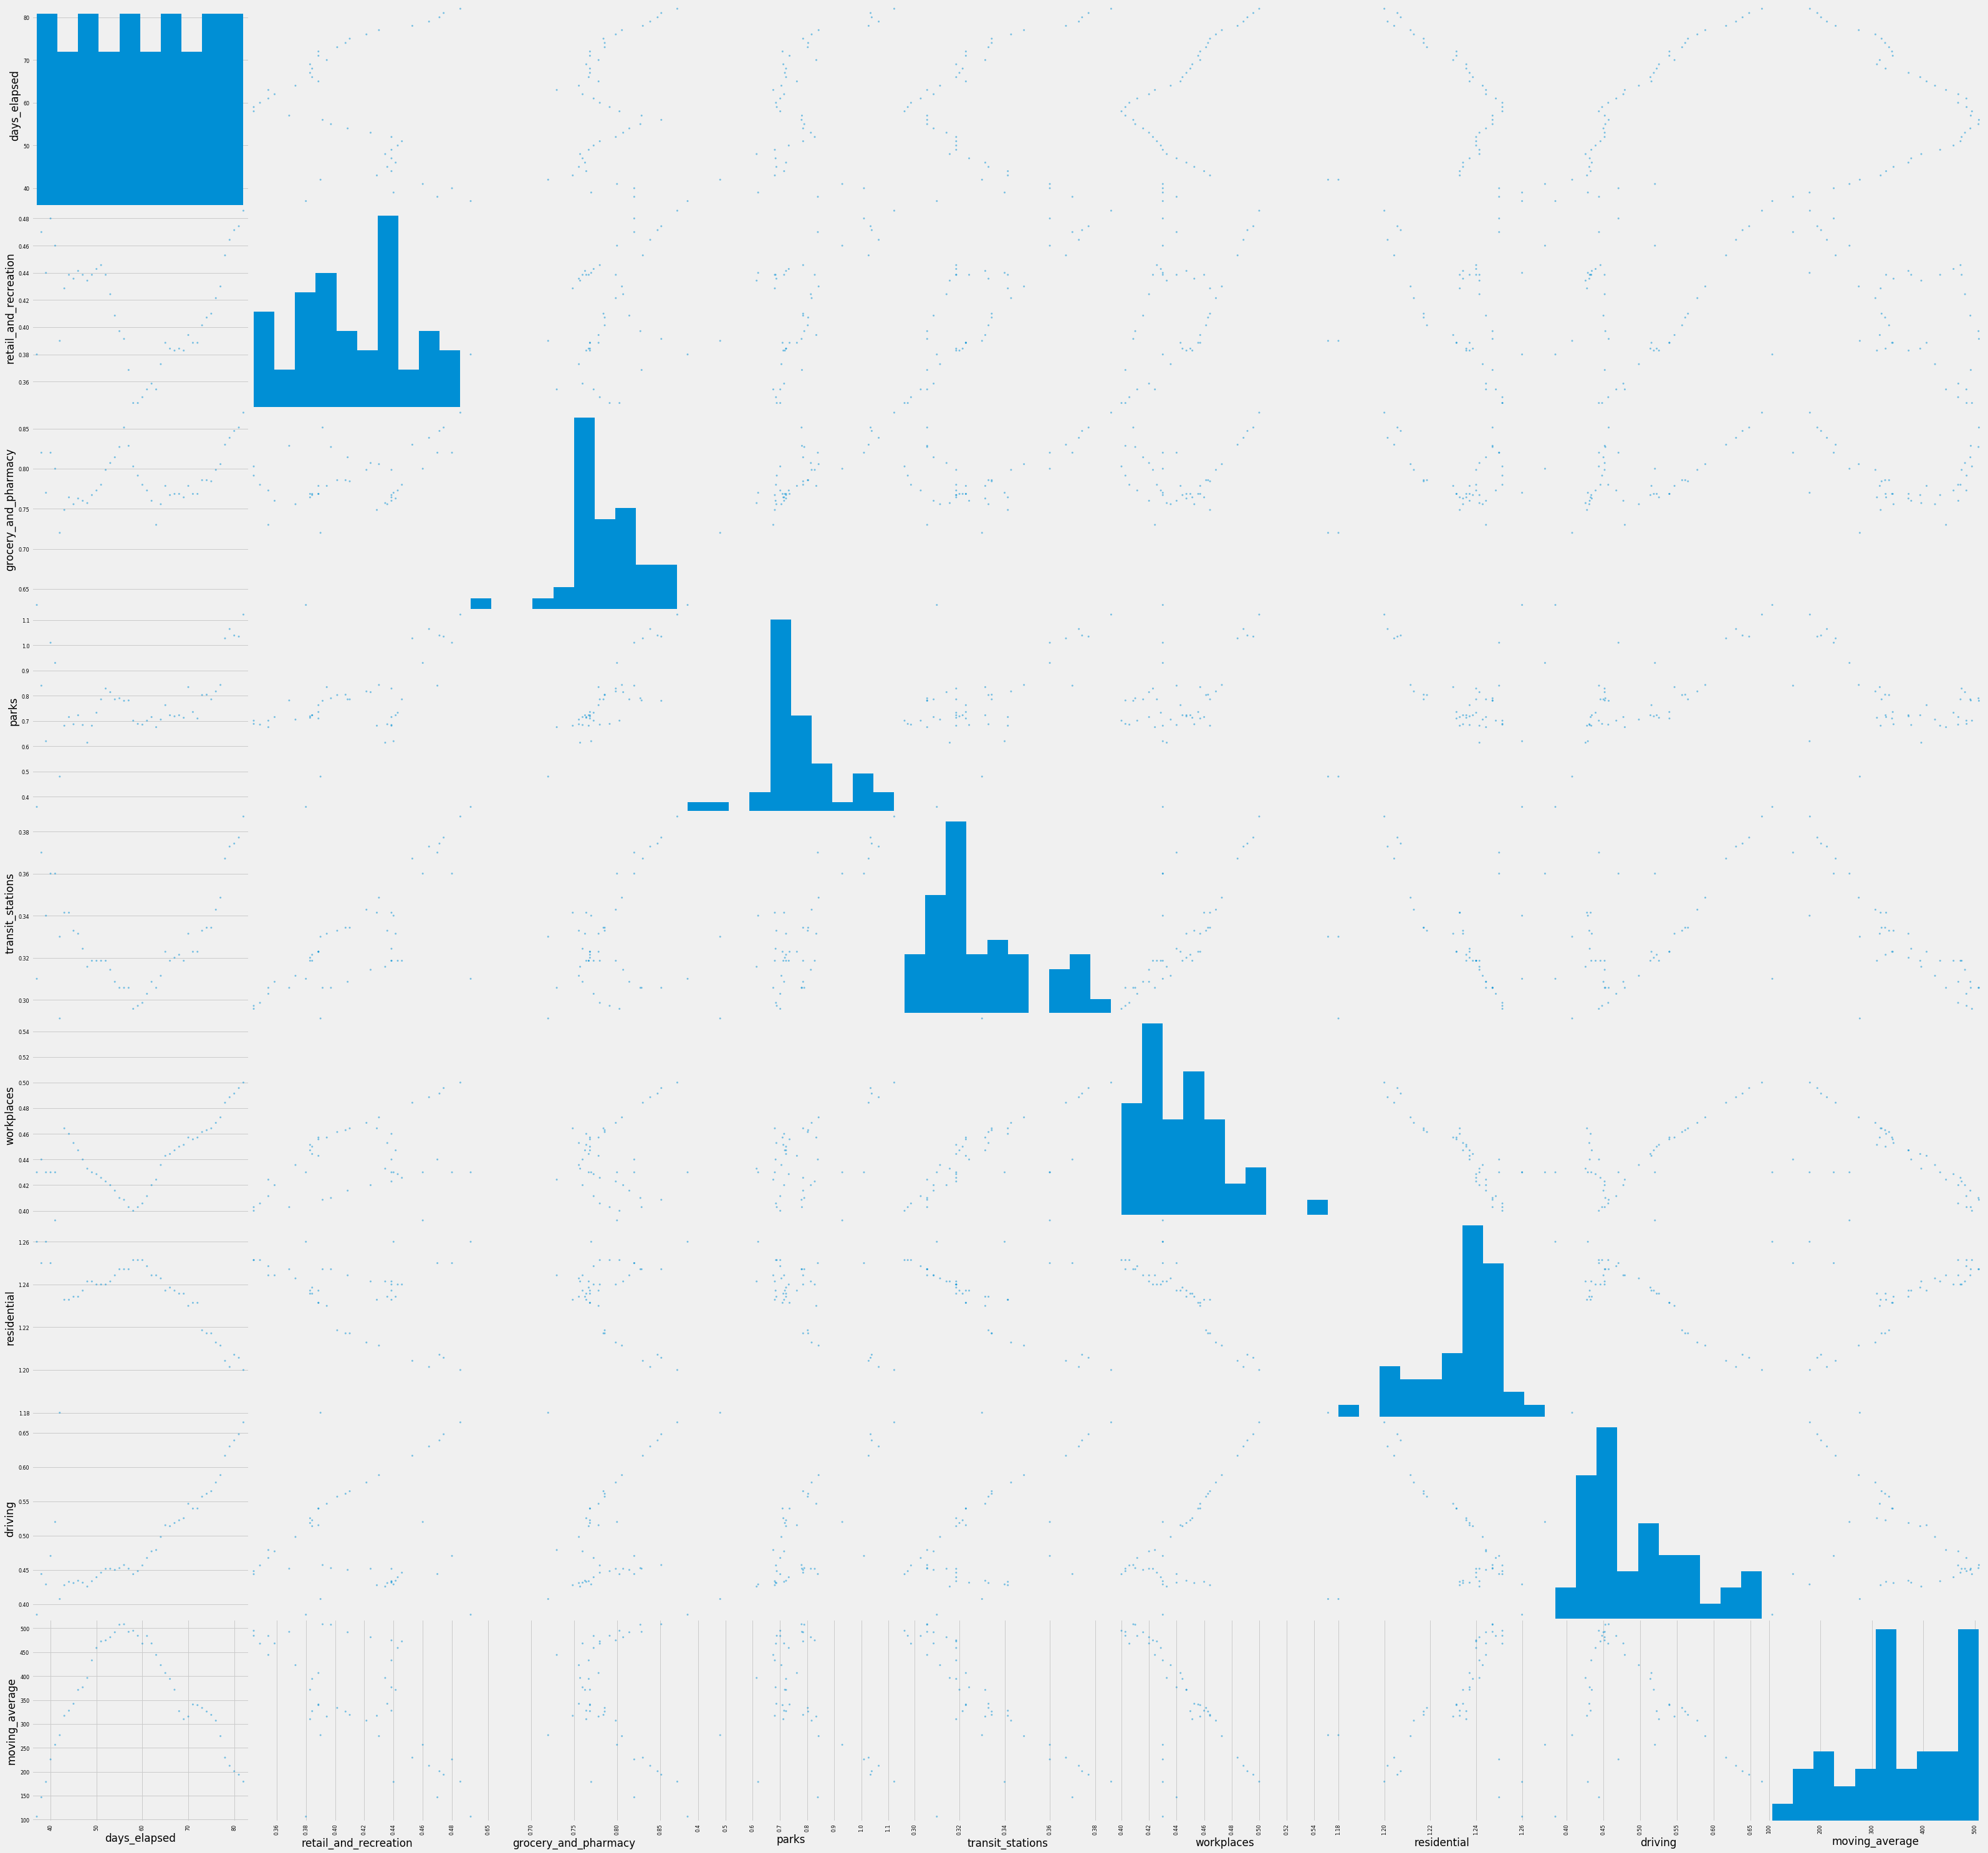

In [84]:
scatter100 = scatter_matrix(sm, figsize = (50,50))

In [86]:
plt.savefig('images/scatter100')

<Figure size 432x288 with 0 Axes>

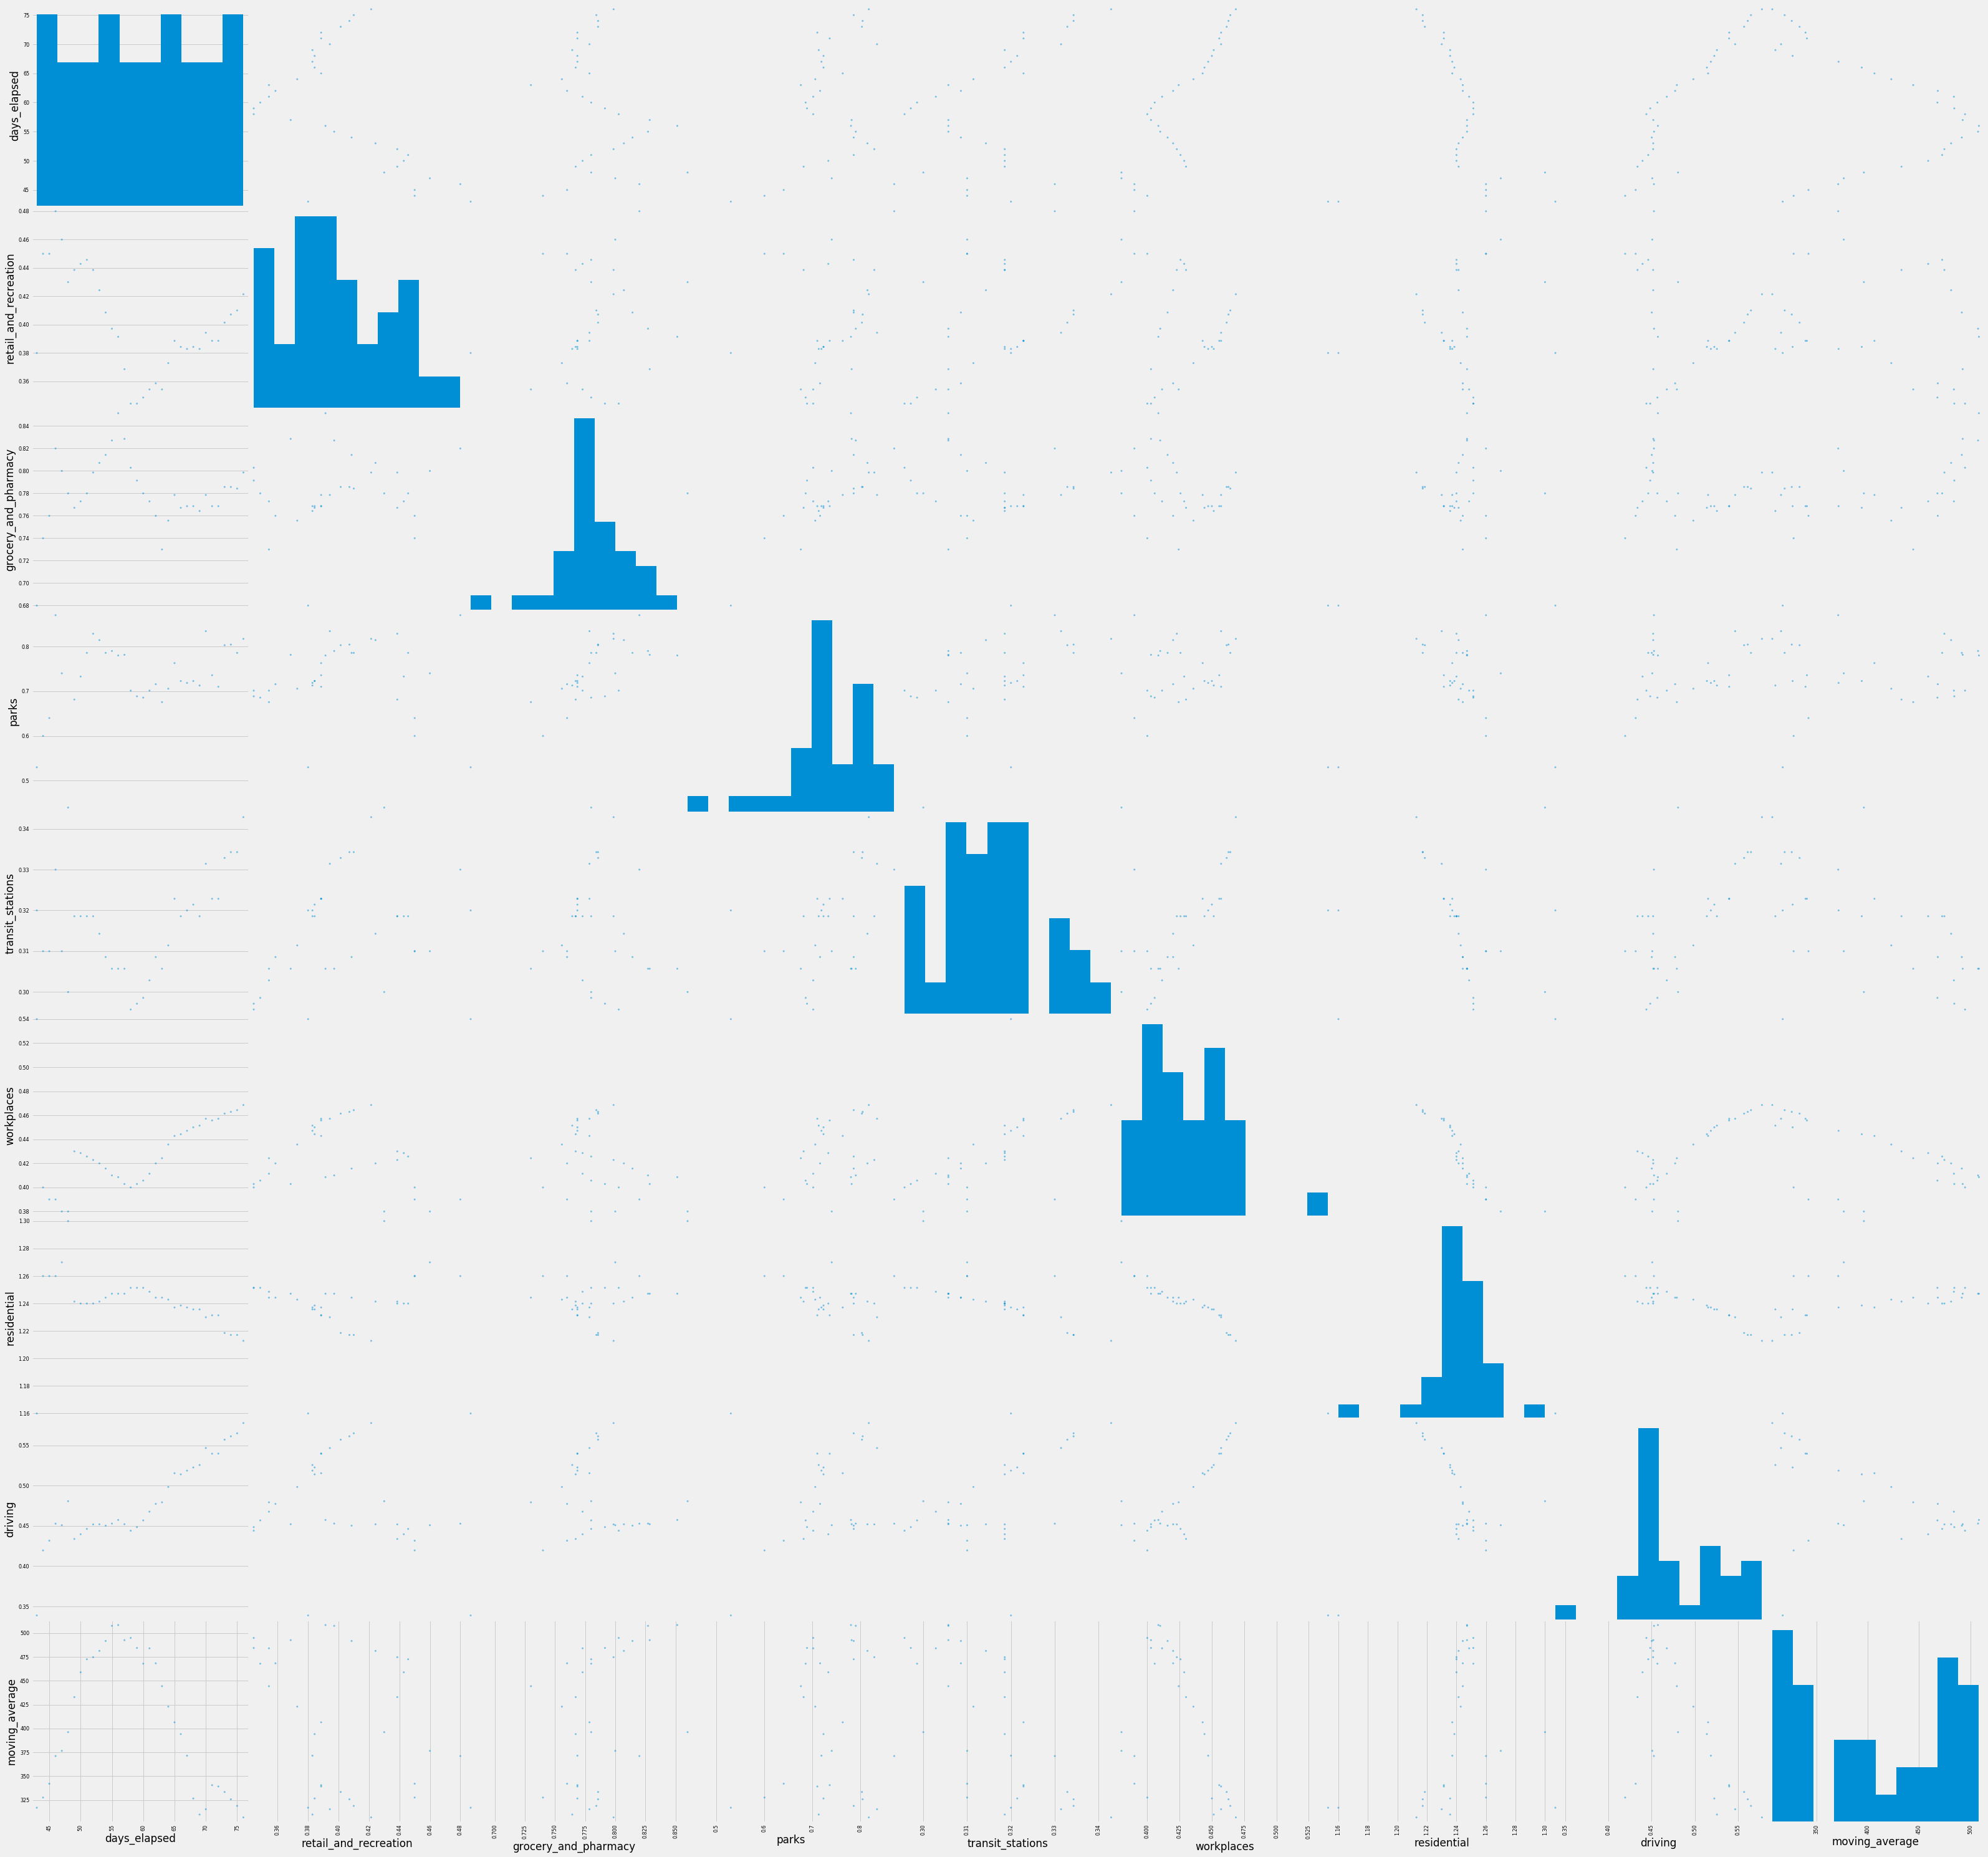

In [148]:
#Using 300 threshold
sm = revised_df.drop('pop_density', axis = 1)
scatter300 = scatter_matrix(sm, figsize = (50,50))

In [149]:
plt.savefig('NYscatter300')

<Figure size 432x288 with 0 Axes>

In [249]:
plot_df = revised_df.copy()
plot_df.rename(columns = {'moving_average': "New Cases"})
plot_df.drop('pop_density', axis = 1, inplace = True)
for col in plot_df.columns[1:]:
    max_val = plot_df[col].max()
    plot_df.loc[:,col] = plot_df[col]/max_val

Text(0, 0.5, 'Fraction of Activity to Maximum Value in Interval')

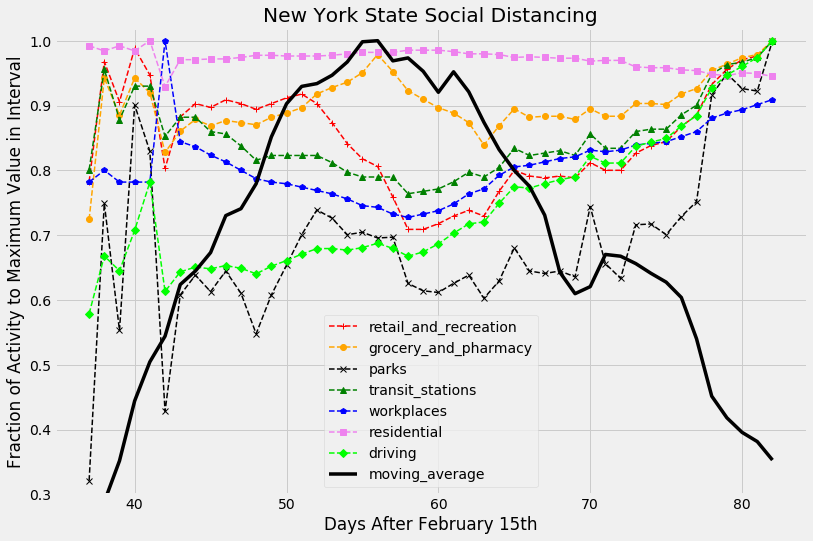

In [254]:
fig, ax = plt.subplots(figsize = (12, 8))
linestyles = ['--', '--', '--', '--', '--', '--', '--', '-']
linewidths = [1.5, 1.5, 1.5, 1.5, 1.5 ,1.5 ,1.5, 3.5]
markers = list('+ox^psD ')
colors = ['red', 'orange', 'black', 'green', 'blue', 'violet', 'lime', 'black']
for i, col in enumerate(plot_df.columns[1:]):
    ax.plot(plot_df['days_elapsed'], plot_df[col], label = col, ls = linestyles[i], linewidth = linewidths[i], c = colors[i], marker = markers[i])
ax.legend()
ax.set_ylim(0.3, 1.02)
ax.set_title('New York State Social Distancing')
ax.set_xlabel('Days After February 15th')
ax.set_ylabel('Fraction of Activity to Maximum Value in Interval')

In [255]:
fig.savefig('images/NY_Social_Distance_days')

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


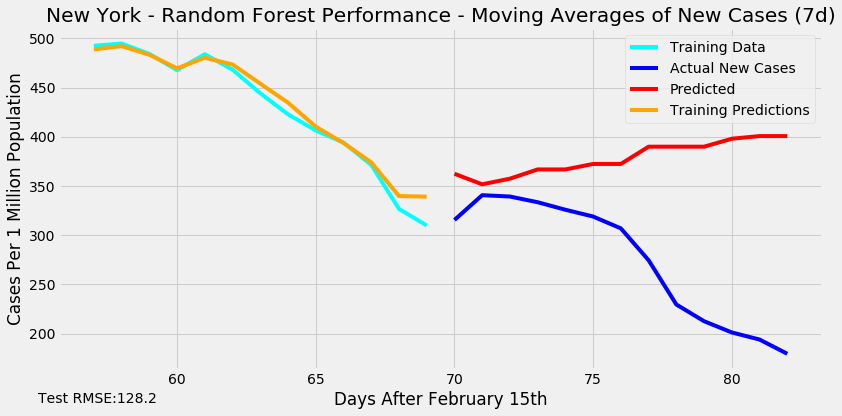

In [61]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(rf_model.X_train['days_elapsed(t)'], rf_model.y_train, label = 'Training Data', color = 'cyan')
ax.plot(rf_model.predicted_vals_df['days_elapsed(t)'], rf_model.predicted_vals_df['moving_average(t)'], label = 'Actual New Cases', color = 'blue')
ax.plot(rf_model.predicted_vals_df['days_elapsed(t)'], rf_model.predicted_vals_df['y_hat'], label = 'Predicted', color = 'red')
ax.plot(rf_model.X_train['days_elapsed(t)'].values, rf_model.model.predict(rf_model.X_train), label = 'Training Predictions', color = 'orange')
ax.set_xlabel('Days After February 15th')
ax.set_ylabel('Cases Per 1 Million Population')
ax.set_title('New York - Random Forest Performance - Moving Averages of New Cases (7d)')
rmse = 'Test RMSE:' + str(round(rf_model.evaluate_model(),1))
ax.text(55,130,rmse)
ax.legend()
fig.tight_layout()
fig.show() 

In [8]:
fig.savefig('images/RF_Performance')

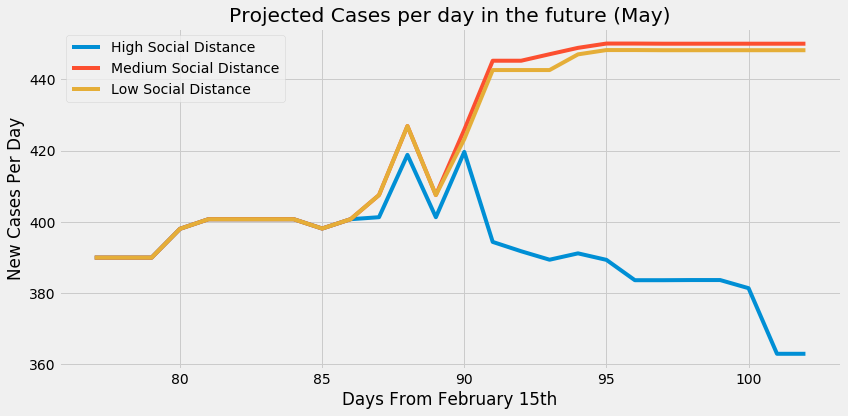

In [62]:
prediction_ts_hi = generate_prediction_df('High', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_hi['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_hi)

prediction_ts_md = generate_prediction_df('Medium', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_md['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_md)

prediction_ts_lw = generate_prediction_df('Low', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_lw['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_lw)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(prediction_ts_hi['days_elapsed(t+20)'] ,prediction_ts_hi['moving_average(t+20)'], label = 'High Social Distance')
ax.plot(prediction_ts_md['days_elapsed(t+20)'] ,prediction_ts_md['moving_average(t+20)'], label = 'Medium Social Distance')
ax.plot(prediction_ts_lw['days_elapsed(t+20)'] ,prediction_ts_lw['moving_average(t+20)'], label = 'Low Social Distance')
ax.legend()
ax.set_title('Projected Cases per day in the future (May)')
ax.set_xlabel('Days From February 15th')
ax.set_ylabel('New Cases Per Day')
fig.tight_layout()

In [63]:
fig.savefig('images/Predictions')